In [1]:
import gzip
import os
import glob

import polars as pl
import pandas as pd
import numpy as np

import geopandas as gpd

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.patches import Patch
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
from matplotlib.lines import Line2D

In [2]:
data_dir = './data'
figure_dir = './figures'
dnsscan_data = f'{data_dir}/dnsscan'
mikrotik_measurement = f'{data_dir}/mikrotik-testing'

response_times_tfwd_vs_rfwd_file = f'{data_dir}/response_times/response_times_tfwd_vs_rfwd.csv'
ratelimit_tests = f'{data_dir}/ratelimits'
rates_file = f'{ratelimit_tests}/rates_scan-24.08.2024_rate-29.08.2024_static_domain_newest_ver.csv'
rates_file_public = f'{ratelimit_tests}/rates_scan-24.08.2024_rate-01.10.2024_public_resolvers.csv'

scan_df_file = f'{dnsscan_data}/udp_dataframe_complete_2025-01-06.csv.gz'

rates_shielded_file = f'{ratelimit_tests}/2025-01-12_15-40-44_rm-direct_dm-constant_incr-2000ms_max-rate-3000pps.csv'
ratelimit_google_file = f'{ratelimit_tests}/2024-10-22_11-27-12_rm-direct_dm-constant_incr-2000ms_max-rate-3000pps-8.8.8.8.csv.gz'

freq_over_time_df_file = f'{dnsscan_data}/frequency_per_type_over_time.csv'

scan_overview_file = f'{dnsscan_data}/scan_overview.csv.gz'

shapefile = f'{data_dir}/shapefiles/ne_110m_admin_0_countries.shp'

In [3]:
overview_df = pl.read_csv(scan_overview_file,separator=";")
scan_df = pl.read_csv(scan_df_file, separator=";")
frequency_odns_over_time = pl.read_csv(freq_over_time_df_file,separator=';')

In [4]:
standard_figsize = (8 * 0.7, 5.5 * 0.5)
worldmap_figsize = (8*0.9,5*0.9)
figsize_stability_odns = (8 * 0.7, 5.5 * 0.3)
figsize_tfwd_vs_rfwd = (8 * 0.7, 5 * 0.5)
mikrotik_figsize = (8 * 0.7, 5 * 0.5)
ratelimit_figsize = (8 * 0.7, 5.5 * 0.4)
date_formatter_month_year = DateFormatter("%b '%y")
date_formatter_month_day_year = DateFormatter("%b %d, '%y")

In [5]:
figure_counter = 0

In [6]:
def y_axis_formatter(x, pos):
    if x >= 1_000_000:
        return f'{x/1_000_000:.1f}M'
    return f'{x/1_000:.0f}k'

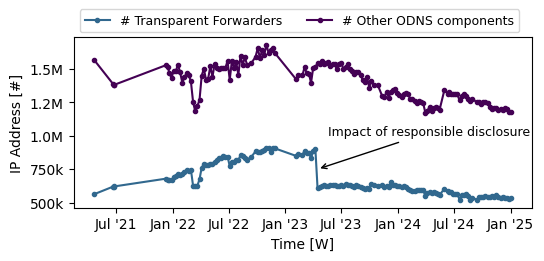

In [7]:
figure_counter += 1

tmp_df = overview_df.with_columns(pl.col("Date").str.strptime(pl.Date, "%Y-%m-%d").alias("Date"))
tmp_df = tmp_df.with_columns(
    (pl.col('# Recursive Forwarders') + pl.col('# Recursive Resolvers')).alias('# Other ODNS components')
)

dates = tmp_df["Date"].to_list()
transparent_forwarders = tmp_df["# Transparent Forwarders"].to_list()
other = tmp_df["# Other ODNS components"].to_list()


plt.figure(figsize=standard_figsize)
plt.plot(dates, transparent_forwarders, marker='o', ms=3, label="# Transparent Forwarders",color="#31688e")
plt.plot(dates, other, marker='o', ms=3, label="# Other ODNS components",color="#440154")
plt.xlabel("Time [W]")
plt.ylabel("IP Address [#]")
plt.legend(loc="upper left", fontsize=9, ncols=2,bbox_to_anchor=(0,1.2))
#plt.grid(True)

plt.gca().xaxis.set_major_formatter(date_formatter_month_year)
plt.gcf().autofmt_xdate(rotation=0,ha='center')
plt.tight_layout()
plt.annotate(
    'Impact of responsible disclosure',
    xy=(pd.to_datetime("2023-04-15"), 750000),
    xytext=(pd.to_datetime("2023-05-20"), 1000000),
    arrowprops=dict(
        facecolor='black',
        arrowstyle='->',
    ),
    zorder=3,
    fontsize=9
)
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))
plt.savefig(f'{figure_dir}/figure_{figure_counter:0=2d}_number_odns_all_year.pdf', bbox_inches='tight')
plt.show()

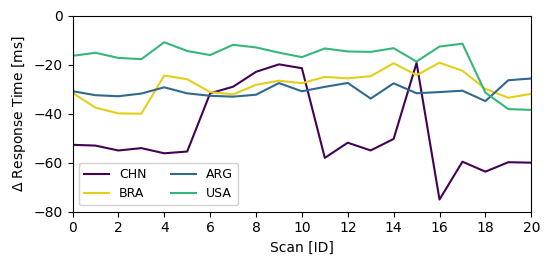

In [8]:
response_times_df = pl.read_csv(response_times_tfwd_vs_rfwd_file,separator=';')
unique_countries = response_times_df["country_request"].unique()
colorlist = {"USA":"#35b779","ARG":"#31688e","BRA":"#e3cf17","CHN":"#440154","IND":"#333254"}#{country: f"C{i}" for i, country in enumerate(unique_countries)}

fig,ax = plt.subplots(figsize=standard_figsize)
for idx, country in enumerate(unique_countries):
    country_df = response_times_df.filter(pl.col("country_request") == country)
    ax.plot(
        country_df["scan_id"],
        country_df["diff_response_time"],
        label=f"{country}",
        #linestyle=line_style,
        color=colorlist[country],
    )
ax.set_ylim(-80,0)
ax.set_xlim(0,20)

plt.xticks(range(int(response_times_df["scan_id"].min()), int(response_times_df["scan_id"].max()) + 1,2))
plt.xlabel("Scan [ID]")
plt.ylabel("$\Delta$ Response Time [ms]")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc="lower left", fontsize=9,ncol=2,framealpha=0.9)
#plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.05))
#plt.grid(axis='y')

# Show the plot
plt.tight_layout()
figure_counter = 4
plt.savefig(f'{figure_dir}/figure_{figure_counter:0=2d}_response_times.pdf', bbox_inches='tight')
plt.show()

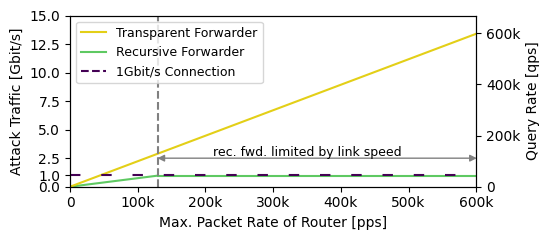

In [9]:
fig, ax1 = plt.subplots(figsize=figsize_tfwd_vs_rfwd)#2,1, sharex= True, figsize=(8 * 0.7, 5.5 * 0.7), gridspec_kw={'height_ratios': [3, 1]})
ax1.plot([0, 130], [0, 0.975], linestyle='-', color='#5ec962', zorder=1) #rising slope rfwd
ax1.plot([130, 600], [0.975, 0.975], linestyle='-', color='#5ec962', zorder=1) #rfwd horizontal
ax1.plot([0, 600], [0, 13.4], linestyle='-', color='#e3cf17', zorder=1) #tfwd
ax1.plot([130, 130], [0, 15], linestyle='--', color='gray') #tfwd
#ax1.text(100, 1.5, "[130;0.975]",fontsize=9) # rfwd limit description
#ax1.text(450, 1.5, "[560;0.975]",fontsize=9) # rfwd limit description
#ax1.text(450, 11.5, "[560;12.5]",fontsize=9) # rfwd limit description
cap_rfwd_line, = ax1.plot([0, 600], [1, 1], linestyle='--', color='#440154', zorder=2) #1gbit
cap_rfwd_line.set_dashes([5, 10])
#ax1.scatter([ 560, 560],[0.975, 12.5], color="gray", marker='x', zorder=3)
ax1.set_ylim([0,15])
ax1.set_ylabel('Attack Traffic [Gbit/s]')
default_ticks = ax1.get_yticks()
all_ticks = sorted(set(default_ticks).union([1]))
ax1.set_yticks(all_ticks)
ax1.annotate(
    '', xy=(125, 2.5), xytext=(605, 2.5),
    arrowprops=dict(arrowstyle='<|-|>', color='gray', lw=1)
)
ax1.text(
    350, 3, 'rec. fwd. limited by link speed',
    ha='center', va='center', color='black', fontsize=9
)
def add_k_formatter(x, _):
    if int(x) == 0:
        return "0"
    return f"{int(x)}k"
ax1.xaxis.set_major_formatter(plt.FuncFormatter(add_k_formatter))

ax2 = ax1.twinx()
ax2.set_ylabel("Query Rate [qps]")
ax2.tick_params(axis='y')
ax2.set_ylim(0, 15/2800/8*1000000)

ax2.set_xticks(ax1.get_xticks())
ax2.yaxis.set_major_formatter(plt.FuncFormatter(add_k_formatter))
ax1.set_xlabel('Max. Packet Rate of Router [pps]')

legend_patches = [
    plt.Line2D([0], [0], color='#e3cf17', linestyle='-', label='Transparent Forwarder'),
    plt.Line2D([0], [0], color='#5ec962', linestyle='-', label='Recursive Forwarder'),
    plt.Line2D([0], [0], color='#440154', linestyle='--', label='1Gbit/s Connection'),
]
plt.legend(handles=legend_patches, loc="upper left", fontsize=9)

plt.xlim([0,600])
plt.tight_layout()
figure_counter = 6
plt.savefig(f"{figure_dir}/figure_{figure_counter:0=2d}_tfwd_vs_rfwd_traffic_victim.pdf", bbox_inches="tight")
plt.show()

In [10]:
files = [f"{mikrotik_measurement}/2025-04-08_15-11-09_recursive_1514_byte_TXT_non_fragmented/ratelimit_record_192.168.88.1.csv",
         f"{mikrotik_measurement}/2025-04-08_15-14-11_recursive_3280_byte_TXT_fragmented_40_times_amplified/ratelimit_record_192.168.88.1.csv",
         f"{mikrotik_measurement}/2025-04-09_13-32-56_transparent_1514_byte_TXT_non_fragmented_40000pps/ratelimit_record_192.168.88.1.csv",
         f"{mikrotik_measurement}/2025-04-08_15-22-35_transparent_3280_byte_TXT_fragmented_40_times_amplified/ratelimit_record_192.168.88.1.csv"]
measurements = ["rec_1514",
                "rec_3280",
                "trans_1514",
                #"trans_3028",
                "trans_3280"]
legend_labels = ["recursive, nonfragmented",
                "recursive, 2x fragmented",
                "transparent, nonfragmented",
                #"transparent, 1x fragmented",
                "transparent, 2x fragmented"]
mikrotik_df = None
for idx, file in enumerate(files):
    df_temp = pl.read_csv(file, separator=";", has_header=False, new_columns=["target-tx-rate","tx-rate","rx-rate","spread"]).with_columns(
        pl.lit(measurements[idx]).alias("tag")
    )
    if mikrotik_df is None:
        mikrotik_df = df_temp
    else:
        mikrotik_df = pl.concat([mikrotik_df, df_temp])
mikrotik_df = (
    mikrotik_df.filter(pl.col("target-tx-rate") != 1200)
    .filter(pl.col("target-tx-rate") != 1300)
    .filter(pl.col("target-tx-rate") != 1400)
    .filter(pl.col("target-tx-rate") != 1600)
    .filter(pl.col("target-tx-rate") != 1700)
    .filter(pl.col("target-tx-rate") != 1800)
    .filter(pl.col("target-tx-rate") != 1900)
    .filter(pl.col("target-tx-rate") != 2100)
    .filter(pl.col("target-tx-rate") != 2200)
    .filter(pl.col("target-tx-rate") != 2300)
    .filter(pl.col("target-tx-rate") != 2400)
    .filter(pl.col("target-tx-rate") != 2600)
    .filter(pl.col("target-tx-rate") != 2700)
    .filter(pl.col("target-tx-rate") != 2800)
    .filter(pl.col("target-tx-rate") != 2900)
    .filter(pl.col("target-tx-rate") < 30005)
)

mikrotik_df = mikrotik_df.with_columns(
    (mikrotik_df["spread"] / mikrotik_df["tx-rate"] * 100).alias("spread_pct"),
    (mikrotik_df["tx-rate"] * 82 * 8 / 1e6).alias("tx-traffic"),
    (mikrotik_df["rx-rate"] * mikrotik_df["tag"].str.extract(r"_(\d+)", 1).cast(pl.Int64) * 8 / 1e6).alias("rx-traffic"),
)
mikrotik_df = mikrotik_df.with_columns(
    (mikrotik_df["rx-traffic"] / mikrotik_df["tx-traffic"] ).alias("qfactor"),
)

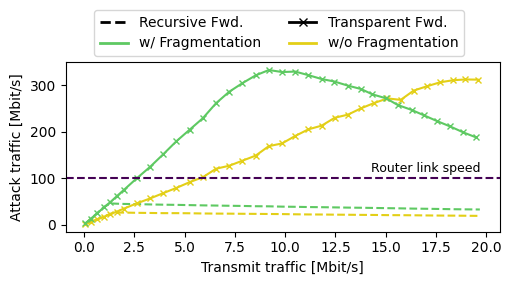

In [11]:
colorlist = ["#e3cf17","#5ec962","#e3cf17","#5ec962"]
markers = ["1","2","3","4","+","x"]
plt.figure(figsize=ratelimit_figsize)
ax = plt.gca()
for idx, measurement in enumerate(measurements):
    df_part = mikrotik_df.filter(mikrotik_df["tag"] == measurement)
    linestyle="--" if 'rec' in measurement else "-"
    marker=None if 'rec' in measurement else "x"
    ax.plot(df_part["tx-traffic"], df_part["rx-traffic"], label=measurement, ms=4, marker=marker, color=colorlist[idx], linestyle=linestyle, zorder=0)

#ax.axvline(x=14009*82*8/1e6, color='gray', linestyle='--', linewidth=1, zorder=1)
#ax.axhline(y=np.max((df_part["rx-rate"]*3280*8/1e6).to_list()), color='gray', linestyle='--', linewidth=1, zorder=1)
ax.axhline(y=100, linestyle='--', color='#440154', zorder=2) #100mbit
ax.set_ylabel("Attack traffic [Mbit/s]")
ax.grid(False)
ax.set_xlabel("Transmit traffic [Mbit/s]")

ax.text(
    17, 120, 'Router link speed',
    ha='center', va='center', color='black', fontsize=9,
    zorder=2
)

handles = [
 Line2D([], [], color='black', linestyle='--', linewidth=2, label='Recursive Fwd.'),
 Line2D([], [], color=colorlist[1], linestyle='-', linewidth=2, label='w/ Fragmentation'),
 Line2D([], [], color='black', linestyle='-',marker='x', linewidth=2, label='Transparent Fwd.'),
 Line2D([], [], color=colorlist[2], linestyle='-', linewidth=2, label='w/o Fragmentation')
]

ax.legend(
    handles=handles,
    loc='upper left',
    bbox_to_anchor=(0.05, 1.35),
    ncols=2,
)

#plt.tight_layout()
figure_counter+=1
plt.savefig(f'{figure_dir}/figure_{figure_counter:0=2d}_mikrotik_comparison.pdf',bbox_inches='tight')
plt.show()

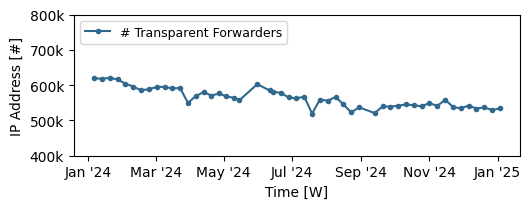

In [12]:
tmp_df = overview_df.with_columns(pl.col("Date").str.strptime(pl.Date, "%Y-%m-%d").alias("Date"))
tmp_df = tmp_df.with_columns(
    (pl.col('# Recursive Forwarders') + pl.col('# Recursive Resolvers')).alias('# Other ODNS components')
)
tmp_df = tmp_df.filter(pl.col("Date")>=pd.to_datetime("2024-01-01"))

dates = tmp_df["Date"].to_list()
transparent_forwarders = tmp_df["# Transparent Forwarders"].to_list()
other = tmp_df["# Other ODNS components"].to_list()

plt.figure(figsize=ratelimit_figsize)
plt.plot(dates, transparent_forwarders, marker='o', ms=3, label="# Transparent Forwarders",color="#31688e")
#plt.plot(dates, other, marker='o', ms=3, label="# Other ODNS components",color="#440154")
plt.xlabel("Time [W]")
plt.ylabel("IP Address [#]")
plt.legend(loc="upper left", fontsize=9, ncols=2,bbox_to_anchor=(0,1))
plt.ylim(400000,800000)
#plt.grid(True)
plt.gca().xaxis.set_major_formatter(date_formatter_month_year)
plt.gcf().autofmt_xdate(rotation=0,ha='center')
plt.tight_layout()

plt.gca().yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))
figure_counter+=1
plt.savefig(f'{figure_dir}/figure_{figure_counter:0=2d}_number_tfwd_year.pdf', bbox_inches='tight')
plt.show()

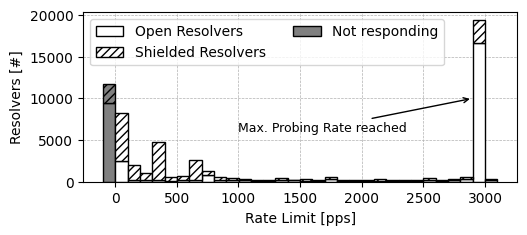

In [13]:
max_rate = 3100
rates_header_df = pd.read_csv(rates_file, sep=';', names=['resolver_ip','max_rate', 'end_rate'])

rates_header_df_pub = pd.read_csv(rates_file_public, sep=';', names=['resolver_ip','max_rate', 'end_rate'])

bins = np.arange(0, rates_header_df['max_rate'].max() + 100, 100)

# drop the duplication ones
drop_rates = rates_header_df[rates_header_df['max_rate'] < max_rate]['max_rate']
drop_rates_pub = rates_header_df_pub[rates_header_df_pub['max_rate'] < max_rate]['max_rate']

plt.figure(figsize=ratelimit_figsize)
plt.gca().grid(True, which='major', linestyle='--', linewidth=0.5, zorder=0)
bins = np.arange(-99, drop_rates.max() + 100, 100)
counts, bins, patches = plt.hist(drop_rates_pub, bins=bins, edgecolor='black', color='white', zorder=2) #lightskyblue

counts2, _, patches2 = plt.hist(drop_rates, bins=bins, edgecolor='black', color='white', label='Drop Rates Pub', hatch='/', histtype='bar', bottom=counts, zorder=2)

for i, (count, patch) in enumerate(zip(counts, patches)):
    if i==0:
        patch.set_facecolor('gray')
    elif i>=30:
        patch.set_facecolor('white')

for i, (count, patch) in enumerate(zip(counts2, patches2)):
    if i==0:
        patch.set_facecolor('gray')
    elif i>=30:
        patch.set_facecolor('white')

for patch in patches2:
    patch.set_hatch('////')

legend_patches = [
    Patch(facecolor='white', edgecolor='black', label='Open Resolvers'),
    Patch(facecolor='white', edgecolor='black',label='Shielded Resolvers', hatch='////'),
    Patch(facecolor='gray', edgecolor='black', label='Not responding')
]

plt.annotate(
    'Max. Probing Rate reached',
    xy=(2900, 10000),
    xytext=(1000, 6000),
    arrowprops=dict(
        facecolor='black',
        arrowstyle='->',
    ),
    zorder=3,
    fontsize=9
)

plt.legend(handles=legend_patches, loc='upper left',ncols=2)

plt.xlabel('Rate Limit [pps]')
plt.ylabel('Resolvers [#]')
figure_counter += 1
plt.savefig(f'{figure_dir}/figure_{figure_counter:0=2d}_ratelimit_resolvers.pdf', bbox_inches='tight')

plt.show()

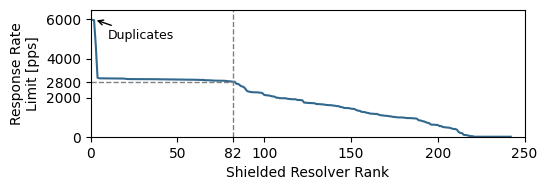

In [14]:
_nottfwd = scan_df.filter(pl.col("response_type") != "Transparent Forwarder")
known_ases = list(set(_nottfwd["asn_request"].to_list() + _nottfwd["asn_response"].to_list() + _nottfwd["asn_arecord"].to_list()))

response_addresses = (
    scan_df
    .filter(pl.col("response_type") != "Transparent Forwarder")
    .select("ip_response")
    .unique()
)

tfwd_shielded_df = (
    scan_df
    .filter(pl.col("response_type") == "Transparent Forwarder")
    .filter(~pl.col("ip_response").is_in(response_addresses))
)
_shielded_ases = (
    tfwd_shielded_df
    .select("asn_response")
    .unique()
)
new_ases = (
    _shielded_ases
    .filter(~pl.col("asn_response").is_in(known_ases))
)

rates_shielded = pl.read_csv(
    rates_shielded_file,
    separator=";",
    has_header=False,
    new_columns=["ip","max_rate","end_rate"]
).select("ip","max_rate")

new_as_tfwds_rate = (
    rates_shielded
    .join(
        tfwd_shielded_df.select("ip_response","asn_response").group_by(["ip_response","asn_response"]).agg(pl.len()),
        left_on = "ip",
        right_on = "ip_response",
        how = "left"
    ).drop_nulls()
    .filter(pl.col("asn_response").is_in(new_ases))
)

_as_rates = (
    new_as_tfwds_rate.group_by("asn_response")
    .agg(
        pl.col("max_rate").max().alias("max_rate_asn")
    )
    .with_columns(
        pl.when(pl.col("max_rate_asn") > 2500)
        .then(pl.lit("red"))
        .otherwise(pl.lit("blue"))
        .alias("color")
    ).sort(by="max_rate_asn", descending=True)
)

plt.figure(figsize=figsize_stability_odns)
plt.plot(range(1,new_as_tfwds_rate.select(pl.len()).item()+1),
        new_as_tfwds_rate.sort(by="max_rate",descending=True)["max_rate"],
        color="#31688e")
plt.annotate(
    'Duplicates',
    xy=(2, 6000),
    xytext=(10, 5000),
    arrowprops=dict(
        facecolor='black',
        arrowstyle='->',
    ),
    zorder=1,
    fontsize=9
)
plt.xticks(list(plt.xticks()[0]) + [82])
plt.yticks(list(plt.yticks()[0]) + [2800])
plt.axvline(x=82, color='gray', linestyle='--', linewidth=1, label='y=64')

plt.hlines(
    y=2800,
    xmin=0,
    xmax=82,
    color="gray",
    linewidth=1,
    linestyle='--'
)
plt.xlabel("Shielded Resolver Rank")
plt.ylabel("Response Rate\nLimit [pps]")
plt.xlim([0,250])
plt.ylim([0,6500])
figure_counter+=1
plt.savefig(f'{figure_dir}/figure_{figure_counter:0=2d}_rrls_new_ases.pdf', bbox_inches='tight')
plt.show()

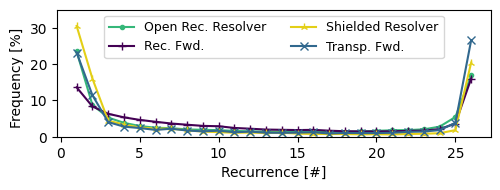

In [15]:
response_types = frequency_odns_over_time['response_type'].unique()
markers = ['.', '+', '2', 'x', 'D', '*']
plt.figure(figsize=figsize_stability_odns)
colorlist = ["#35b779","#440154","#e3cf17","#31688e"]
for i, response_type in enumerate(sorted(response_types)):
    subset = frequency_odns_over_time.filter(pl.col('response_type') == response_type)
    plt.plot(subset['frequency'], subset['rel_amount'], 
             marker=markers[i % len(markers)], 
             label=response_type, linestyle='-', markersize=6, color=colorlist[i])
plt.legend(fontsize=9, loc="upper center", ncols=2)
#plt.yscale('log')
plt.ylim(0, 35)
#plt.ylim(10**-1/2*4,10**2)
plt.xlabel('Recurrence [#]')
plt.ylabel('Frequency [%]  ')
#plt.grid(True, which='both', linestyle='--', linewidth=0.5)
figure_counter += 1
plt.savefig(f'{figure_dir}/figure_{figure_counter:0=2d}_stability_of_odns_components.pdf', bbox_inches='tight')
plt.show()

In [16]:
gdf = gpd.read_file(shapefile)[["ADMIN","ADM0_A3","geometry"]]    
gdf.columns = ["country","country_code","geometry"]    
gdf = gdf.drop(gdf[gdf["country"]=="Antarctica"].index)
geodata = gdf.merge(scan_df.filter(pl.col('response_type')=='Transparent Forwarder').to_pandas().groupby('country_request',as_index=False).size(), left_on = 'country_code', right_on = 'country_request',how="left")
geodata['size'] = geodata['size'].fillna(1)

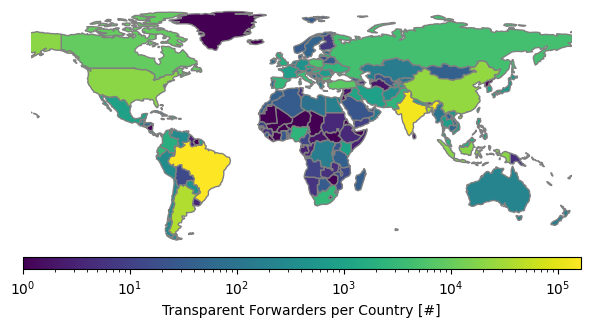

In [17]:
fig, ax = plt.subplots(figsize=worldmap_figsize)
ax.axis("off")

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

geodata.plot(column="size", figsize=worldmap_figsize,cmap="viridis",legend=True, 
             norm=colors.LogNorm(vmin=geodata["size"].min(), vmax=geodata["size"].max()),
             legend_kwds={"label": "Transparent Forwarders per Country [#]", "orientation": "horizontal","shrink":.75,'location':'bottom'},
             cax=cax,ax=ax,edgecolor='grey')

ax.set_xlim(-160,180)
ax.set_ylim(-60,85)

figure_counter += 1
plt.savefig(f'{figure_dir}/figure_{figure_counter:0=2d}_worldmap_tfwd_deployment.pdf',bbox_inches='tight')
# save and clean up
plt.show()
plt.close()

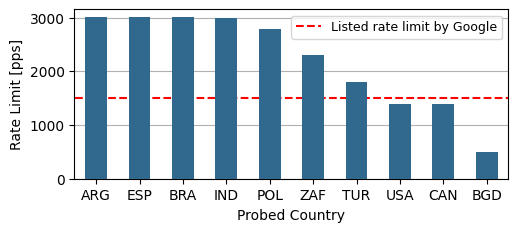

In [18]:
ratelimit_google = pd.read_csv(ratelimit_google_file, parse_dates=True, sep=';', names=['tfwd-ip','timestamp','payload'],skiprows=11,usecols=range(1,4))

ratelimit_google['timestamp']= pd.to_datetime(ratelimit_google['timestamp'], unit='us')

# List of IPs and their corresponding labels for the plot
ip_list = [
    ('189.76.74.121', 'BRA'),
    ('103.194.156.226', 'IND'),
    ('192.75.11.25', 'USA'),
    ('84.38.241.153', 'TUR'),
    ('178.212.52.204', 'POL'),
    ('185.209.194.25', 'ESP'),
    ('170.39.243.151', 'CAN'),
    ('190.120.124.182', 'ARG'),
    ('103.239.42.162', 'BGD'),
    ('196.251.197.247', 'ZAF')
]

ip_list_map = {
    '189.76.74.121': 'BRA',
    '103.194.156.226': 'IND',
    '192.75.11.25': 'USA',
    '84.38.241.153': 'TUR',
    '178.212.52.204': 'POL',
    '185.209.194.25': 'ESP',
    '170.39.243.151': 'CAN',
    '190.120.124.182': 'ARG',
    '103.239.42.162': 'BGD',
    '196.251.197.247': 'ZAF'
}

min_timestamp = ratelimit_google['timestamp'].min()

rate_arr = []
for i, (ip, label) in enumerate(ip_list):
    df_sub = ratelimit_google[ratelimit_google['tfwd-ip'] == ip]
    df_sub = df_sub.set_index('timestamp').sort_index()
    rolling_count = df_sub.rolling('1s').count()['payload']
    # Convert the time index to seconds relative to min_timestamp
    relative_time_index = (rolling_count.index - min_timestamp).total_seconds()
    rate_arr.append((ip_list_map[ip],rolling_count.iloc[-1]))
    
rate_arr.sort(key=lambda x: x[1], reverse=True)
x=[rate[0] for rate in rate_arr]
y=[rate[1] for rate in rate_arr]
plt.figure(figsize=ratelimit_figsize)
plt.grid(axis="y")
plt.bar(x,y, color="#31688e", width=0.5, zorder=3)
plt.hlines(y=1500,xmin=-1, xmax=9.5, color='red',linestyle='--',zorder=2,label="Listed rate limit by Google")
plt.xlabel("Probed Country")
plt.ylabel("Rate Limit [pps]")
plt.xlim([-0.5,9.5])
plt.legend(fontsize=9)
figure_counter += 1
plt.savefig(f'{figure_dir}/figure_{figure_counter:0=2d}_google_rate_limit_multiple_countries.pdf', bbox_inches='tight')
plt.show()